In [1]:
import os
import numpy as np

from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import random


from skimage.io import imread_collection

K.set_image_data_format('channels_last')



Using TensorFlow backend.


In [2]:
images_raw = imread_collection('../data/Train/CameraRGB/*.png')
labels_raw = imread_collection('../data/Train/CameraSeg/*.png')

images_raw = np.array(images_raw)
labels_raw = np.array(labels_raw)

print(images_raw.shape)
print(labels_raw.shape)

(1000, 600, 800, 3)
(1000, 600, 800, 3)


In [15]:
images = images_raw.astype('float32')
#images = images[:,175:495,:,:]
images = images[:,60:540,:,:]
images = (images - 128) / 128

road_labels = labels_raw[:,60:540,:,0]
road_labels = (road_labels == 7) + (road_labels == 6)
road_labels = np.where(road_labels ,1,0).astype('uint8')
road_labels = road_labels.reshape((road_labels.shape[0],road_labels.shape[1],road_labels.shape[2],1))

#car_labels = labels_raw[:,175:495,:,0]
car_labels = labels_raw[:,60:540,:,0]
car_labels = np.where(car_labels == 10 ,1,0).astype('uint8')
car_labels = car_labels.reshape((car_labels.shape[0],car_labels.shape[1],car_labels.shape[2],1))
car_labels[:,437:480,:,:] = 0  # remove the hood

#Trying out both labels together. 
labels = np.concatenate((road_labels,car_labels),axis=-1)

print(images.shape)
print(road_labels.shape)
print(car_labels.shape)
print(labels.shape)

(1000, 480, 800, 3)
(1000, 480, 800, 1)
(1000, 480, 800, 1)
(1000, 480, 800, 2)


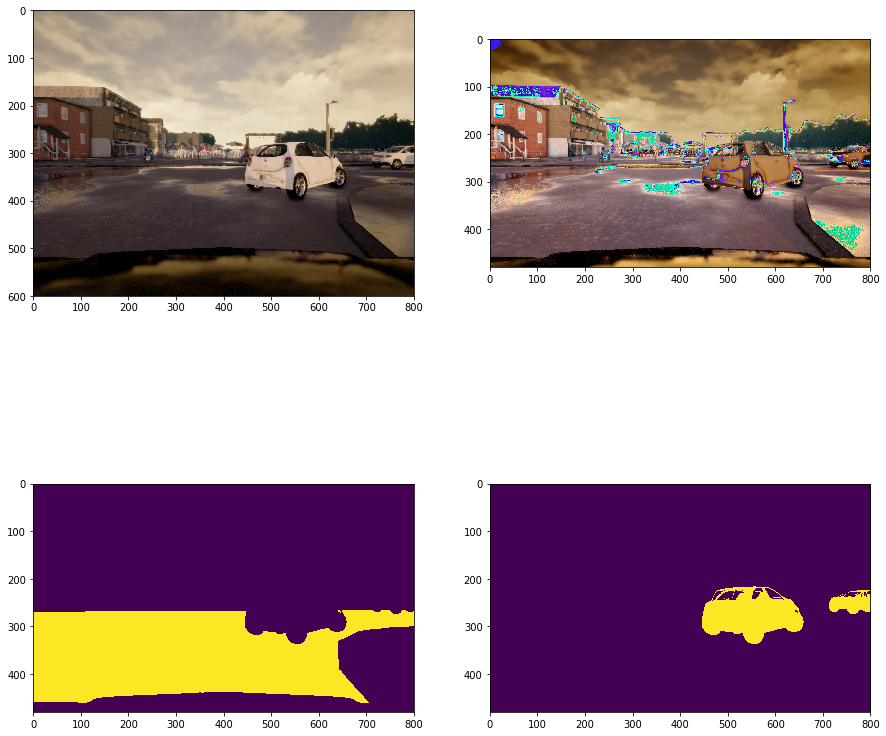

In [16]:
n = 600

fig=plt.figure(figsize=(15, 15))
row = 2
col = 2

fig.add_subplot(row, col, 1)
plt.imshow(images_raw[n]) 

fig.add_subplot(row, col, 2)
plt.imshow(images[n]+1) #plus 1 for moving the mean above '0'

fig.add_subplot(row, col, 3)
plt.imshow(labels[n,:,:,0]) #final 0 to show the mask

fig.add_subplot(row, col, 4)
plt.imshow(labels[n,:,:,1]) #final 0 to show the mask

In [17]:
# Define Loss

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [18]:
# define model 
img_rows = 480
img_cols = 800


def get_unet():
    inputs = Input((img_rows, img_cols, 3))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    #model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [20]:
print('-'*30)
print('Loading and preprocessing train data...')
print('-'*30)

print('-'*30)
print('Creating and compiling model...')
print('-'*30)
full_model = get_unet()
full_model_checkpoint = ModelCheckpoint('full_weights.h5', monitor='val_loss', save_best_only=True)

print('-'*30)
print('Fitting model...')
print('-'*30)
#car_model.load_weights('full_weights.h5')
history = full_model.fit(images, labels, batch_size=2, epochs=2, verbose=1, shuffle=True,
          validation_split=0.2,
          callbacks=[full_model_checkpoint])



------------------------------
Loading and preprocessing train data...
------------------------------
------------------------------
Creating and compiling model...
------------------------------
------------------------------
Fitting model...
------------------------------
Train on 800 samples, validate on 200 samples
Epoch 1/2


InvalidArgumentError: Incompatible shapes: [1536000] vs. [768000]
	 [[Node: metrics_1/dice_coef/mul = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](metrics_1/dice_coef/Reshape, metrics_1/dice_coef/Reshape_1)]]
	 [[Node: metrics_1/dice_coef/Mean/_607 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2661_metrics_1/dice_coef/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'metrics_1/dice_coef/mul', defined at:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-0657c8da5cf1>", line 8, in <module>
    full_model = get_unet()
  File "<ipython-input-18-6567a3df4047>", line 47, in get_unet
    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/keras/engine/training.py", line 934, in compile
    handle_metrics(output_metrics)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/keras/engine/training.py", line 913, in handle_metrics
    mask=masks[i])
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/keras/engine/training.py", line 429, in weighted
    score_array = fn(y_true, y_pred)
  File "<ipython-input-17-efe81c820ae8>", line 8, in dice_coef
    intersection = K.sum(y_true_f * y_pred_f)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 971, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 1198, in _mul_dispatch
    return gen_math_ops.mul(x, y, name=name)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 4689, in mul
    "Mul", x=x, y=y, name=name)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Incompatible shapes: [1536000] vs. [768000]
	 [[Node: metrics_1/dice_coef/mul = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](metrics_1/dice_coef/Reshape, metrics_1/dice_coef/Reshape_1)]]
	 [[Node: metrics_1/dice_coef/Mean/_607 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2661_metrics_1/dice_coef/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


dict_keys(['val_loss', 'val_dice_coef', 'loss', 'dice_coef'])


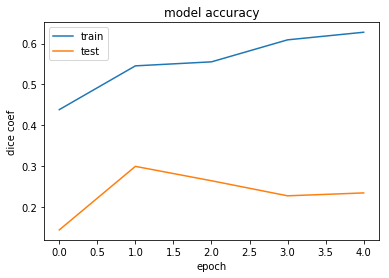

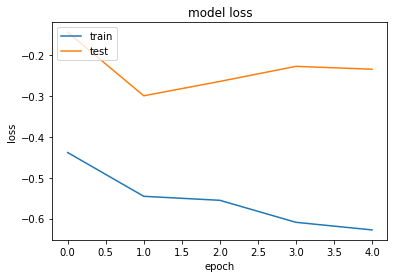

In [31]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('model accuracy')
plt.ylabel('dice coef')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

------------------------------
Loading saved weights...
------------------------------
------------------------------
Predicting masks on test data...
------------------------------
1/1 [==============================] - 0s 55ms/step


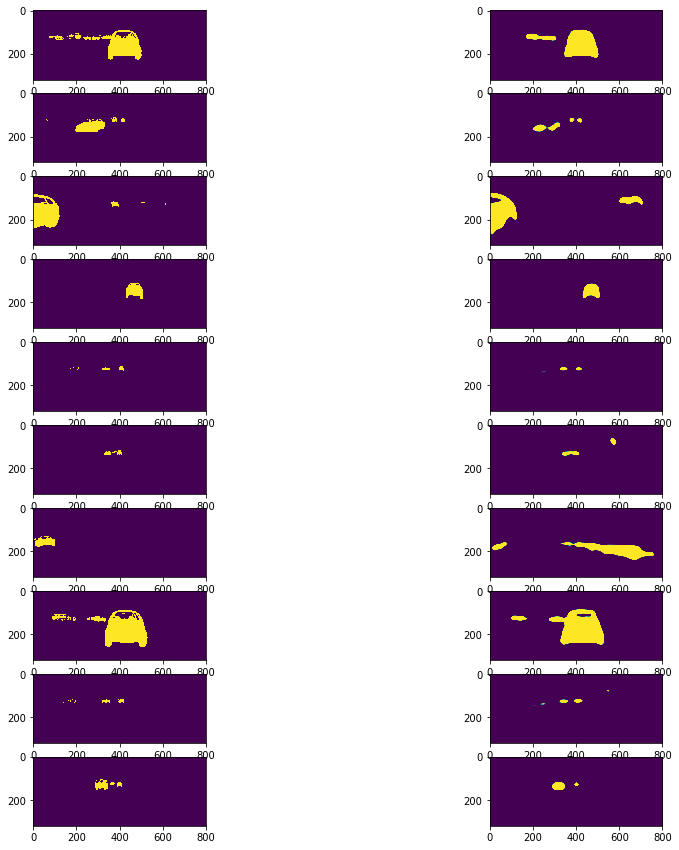

In [48]:
print('-'*30)
print('Loading saved weights...')
print('-'*30)
car_model = get_unet()
car_model.load_weights('carweights.h5')

print('-'*30)
print('Predicting masks on test data...')
print('-'*30)

arr = random.sample(range(1000), 10)

fig=plt.figure(figsize=(15, 15))
row = 10
col = 2

for i in range(len(arr)):
    n = arr[i]
    car_pred = car_model.predict(images[n:n+1,:,:,:], verbose=1)

    #fig.add_subplot(row, col, i*3+1)
    #plt.imshow(images_raw[n]) 

    #fig.add_subplot(row, col, i+2)
    #plt.imshow(images[n]+1) #plus 1 for moving the mean above '0'

    fig.add_subplot(row, col, i*2+1)
    plt.imshow(car_labels[n,:,:,0]) #final 0 to show the mask

    fig.add_subplot(row, col, i*2+2)
    plt.imshow(car_pred[0,:,:,0]) #final 0 to show the mask


(5, 320, 800, 3)
5/5 [==============================] - 1s 173ms/step
(5, 320, 800, 1)


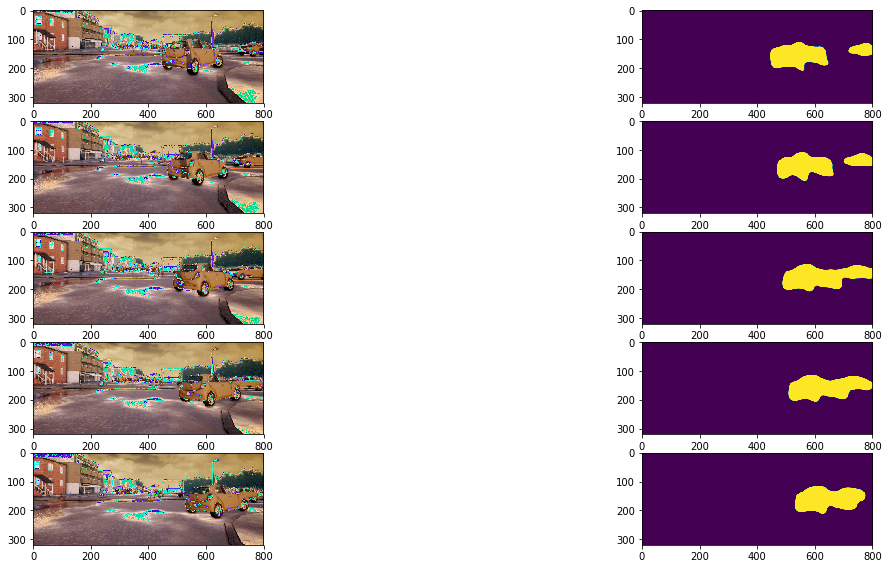

In [45]:
car_images = images[600:605,:,:,:]
print(car_images.shape)


car_model = get_unet()
car_model.load_weights('carweights.h5')


car_preds = car_model.predict(car_images, verbose=1)
print(car_preds.shape)

fig=plt.figure(figsize=(20, 20))
row = 10
col = 2

for i in range(len(car_images)) :
    fig.add_subplot(row, col, i*2+1)
    plt.imshow(car_images[i]+1) #final 0 to show the mask

    fig.add_subplot(row, col, i*2+2)
    plt.imshow(car_preds[i,:,:,0]) #final 0 to show the maskcar_imagei